In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("../../data/processed_data.csv")
data["didnt_blank"] = (data["points_scored"] > 2).astype(int)

In [ ]:
data.columns

Index(['year', 'gw', 'player', 'id', 'points_scored', 'fixture_id',
       'team_name', 'opposition_name', 'form', 'position', 'creativity',
       'influence', 'threat', 'selected', 'playing_chance', 'birth_date',
       'corners_and_free_kicks_order', 'penalties_order', 'yellow_card_90',
       'red_card_90', 'bps_90', 'game_time_percent', 'goals_90', 'assists_90',
       'goals_conceded_90', 'starts_90', 'saves_90', 'clean_sheets_90',
       'team_strength', 'team_strength_attack', 'team_strength_defence',
       'opposition_strength', 'opposition_strength_attack',
       'opposition_strength_defence'],
      dtype='object')

In [ ]:
df = data.copy().drop(columns=["year", "gw", "player", "id", "fixture_id", "team_name", "opposition_name", "birth_date", "points_scored"])


In [21]:
df.head()

,points_scored,form,position,creativity,influence,threat,selected,playing_chance,corners_and_free_kicks_order,penalties_order,...,starts_90,saves_90,clean_sheets_90,team_strength,team_strength_attack,team_strength_defence,opposition_strength,opposition_strength_attack,opposition_strength_defence,didnt_blank
0,0,5.80,2,269.6,915.4,320.0,5.4,100.0,0.0,0.0,...,1.000000,0.0,0.351351,3,1125,1080,5,1370,1360,0
1,0,1.25,2,12.2,39.0,0.0,2.2,NaN,0.0,0.0,...,0.000000,0.0,0.000000,4,1220,1350,3,1120,1085,0
2,0,0.00,3,144.3,73.4,61.0,0.1,0.0,0.0,0.0,...,0.918367,0.0,0.000000,4,1150,1310,2,1020,1060,0
3,0,0.00,2,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0.000000,0.0,0.000000,3,1180,1170,2,1060,1120,0
4,0,4.80,2,311.2,735.0,147.0,2.4,100.0,0.0,0.0,...,1.043599,0.0,0.250464,3,1130,1075,3,1150,1230,0


Before SMOTE: {0: 766, 1: 134}
After SMOTE: {0: 766, 1: 459}


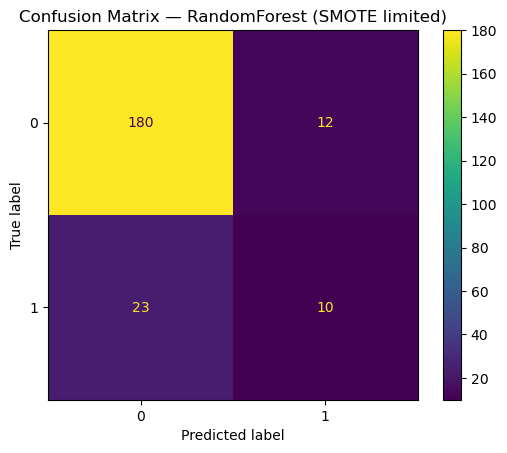

              precision    recall  f1-score   support

           0      0.887     0.938     0.911       192
           1      0.455     0.303     0.364        33

    accuracy                          0.844       225
   macro avg      0.671     0.620     0.638       225
weighted avg      0.823     0.844     0.831       225



In [30]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt

# Load & prepare
df = pd.read_csv("../../data/processed_data.csv")
MIN_MINUTES = 90  # e.g., total minutes in a match
df = df[df["game_time_percent"] >= 1]
drop_cols = ["year","gw","player","id","fixture_id","team_name","opposition_name","birth_date"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

y = (df["points_scored"] > 2).astype(int).values
X = df.drop(columns=["points_scored"])

# Impute missing values
imputer = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imp, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE with limited oversampling (e.g., raise minority to 60% of majority)
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", pd.Series(y_train).value_counts().to_dict())
print("After SMOTE:", pd.Series(y_smote).value_counts().to_dict())

# Train Random Forest
clf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_smote, y_smote)

# Predictions & evaluation
y_pred = clf.predict(X_test)

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion Matrix — RandomForest (SMOTE limited)")
plt.show()

print(classification_report(y_test, y_pred, digits=3))
